### I. Data Import, Cleaning and Processing:

https://infoshare.azwater.gov/docushare/dsweb/Get/Document-12526/37-50_Well_Index_Numbers.pdf

Well number index guide.

55-6XXXX were existing wells, Registered before 6/12/1982

55-8XXXX were existing wells, Registered after 6/12/1982

Should we drop these completely from our data frame? Or just start counting in 1983?..

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# I downloaded 61 files of well data from https://azwatermaps.azwater.gov/WellReg
# This code chunk combines them all into one data frame and removes duplicates.

df_list = []

file_in = "willcox basin/willcox"

for i in range(1,19):
    a = str(i)
    temp = pd.read_excel(file_in + a + ".xlsx")
    df_list.append(temp)
    
df = pd.concat(df_list)

df = df.drop_duplicates()

##### Let's look for missing values and data types:

In [3]:
df.dtypes


Registry No. (55-)              int64
GWSI Site ID                  float64
Cadastral                      object
Owner Name                     object
Well Type                      object
Well Depth (ft)               float64
Casing Depth (ft)             float64
Case Dia (in)                 float64
Drill Date             datetime64[ns]
Applicaiton Date       datetime64[ns]
Water Level (ft)              float64
Pump Capacity (GPM)           float64
Pump Data Available            object
Completion Report              object
Log Received                   object
dtype: object

In [4]:
df.isna().sum()

Registry No. (55-)        0
GWSI Site ID           6388
Cadastral                 0
Owner Name               18
Well Type                 0
Well Depth (ft)         921
Casing Depth (ft)       973
Case Dia (in)           958
Drill Date             2638
Applicaiton Date          5
Water Level (ft)       1035
Pump Capacity (GPM)    2371
Pump Data Available       0
Completion Report      5820
Log Received           4605
dtype: int64

In [5]:
# Rename Owner Name to remove spaces
df.rename(columns = {'Owner Name':'Owner'}, inplace=True)

# Rename Registry number
df.rename(columns = {'Registry No. (55-)':'Registry_Num'}, inplace=True)

# Fix spelling error
df.rename(columns = {'Applicaiton Date':'Application Date'}, inplace=True)

# Change Drill Date column to datetime type
df['Drill Date'] = pd.to_datetime(df['Drill Date'], errors = 'coerce')
df['Application Date'] = pd.to_datetime(df['Application Date'], errors = 'coerce')

# Remove NaN from the Well Depth, Drill Date, and Owner:
df = df.dropna(subset=['Well Depth (ft)'])
df = df.dropna(subset=['Drill Date'])
df = df.dropna(subset=['Owner'])

# Create new column to express the year drilled:
# I'm using Application Date instead of drill date, as I noticed there
# Are several entries where the Drill Date is listed before the Application Date.
df['Year'] = df['Application Date'].dt.year

# However, there's some data issues with the dates in year 1982. For these, we will use the Drill Date instead. 
df["Year"] = np.where(df["Year"] == "1982", 1982, df['Drill Date'].dt.year)

# we shouldn't have well depth or water level of 0:
df = df.loc[df['Well Depth (ft)'] != 0]
df = df.loc[df['Water Level (ft)'] != 0]


In [6]:
## how to handle the "existing wells" index issue for 1982:

# slice the first 4 digits of well number, drop everything that == "55-6" and "55-8"

#well_index = np.linspace(0, len(df), len(df), dtype=int)

well = df['Registry_Num']//100000
well.astype(int)

df['Well#'] = well

# The below two lines drops nearly 50% of the entire data set!
df = df.loc[df['Well#'] != 6]
df = df.loc[df['Well#'] != 8]

In [7]:
# Lets Look at the the well depth statistics in Cochise County:
df["Well Depth (ft)"].describe()
    

count    2698.000000
mean      435.002595
std       371.008174
min         5.000000
25%       125.000000
50%       355.000000
75%       585.000000
max      2509.000000
Name: Well Depth (ft), dtype: float64

In [8]:
# Really? 5679 feet deep?
# This looks like a data error to me. There's only two entries with a depth over 5000 feet. 
# they were both drilled 3 weeks apart in 1982, and the well depth is identical (5679 ft)
# given that the water level is 500 ft, I'm thinking this was a data entry error. 

mx = df[df['Well Depth (ft)'] >= 4500]
mx

,Registry_Num,GWSI Site ID,Cadastral,Owner,Well Type,Well Depth (ft),Casing Depth (ft),Case Dia (in),Drill Date,Application Date,Water Level (ft),Pump Capacity (GPM),Pump Data Available,Completion Report,Log Received,Year,Well#


In [9]:
# Delete these two entries, and all well depths less than 50 ft or greater than 4500 ft.
df = df[df['Well Depth (ft)'] <= 4500]
df = df[df['Well Depth (ft)'] >= 50]

### Pumping data:

In [10]:
df_pump = df.dropna(subset=['Pump Capacity (GPM)'])

In [11]:
df_pump1990 = df_pump[df_pump['Year'] <= 1990]
df_pump1990 = df_pump[df_pump['Year'] >= 1981]

df_pump2000 = df_pump[df_pump['Year'] <= 2000]
df_pump2000 = df_pump[df_pump['Year'] >= 1991]

df_pump2010 = df_pump[df_pump['Year'] <= 2010]
df_pump2010 = df_pump[df_pump['Year'] >= 2001]

df_pump2021 = df_pump[df_pump['Year'] >= 2011]

In [12]:
df_pump1990.describe()

,Registry_Num,GWSI Site ID,Well Depth (ft),Casing Depth (ft),Case Dia (in),Water Level (ft),Pump Capacity (GPM),Year,Well#
count,1290.000000,9.400000e+01,1290.000000,1286.000000,1284.000000,1280.000000,1290.000000,1290.000000,1290.000000
mean,484777.365116,3.186156e+14,343.727907,331.023328,7.968847,198.800781,60.246512,1995.326357,4.528682
std,162125.536568,3.202336e+12,238.836239,238.517433,11.235478,207.741977,236.725056,10.906600,1.638709
min,85098.000000,3.135281e+14,50.000000,0.000000,0.000000,2.000000,0.000000,1981.000000,0.000000
25%,503383.250000,3.153031e+14,143.000000,121.000000,6.000000,71.000000,0.000000,1986.250000,5.000000
50%,521292.500000,3.201116e+14,304.000000,300.000000,8.000000,170.000000,10.000000,1993.000000,5.000000
75%,547811.500000,3.212974e+14,480.000000,463.750000,8.000000,280.500000,20.000000,2002.750000,5.000000
max,926515.000000,3.254531e+14,2137.000000,2137.000000,400.000000,5505.000000,3200.000000,2021.000000,9.000000


### Let's group the well owners into sectors: Riverview, Oil Companies, AZ State, City, Federal, Energy (Gas and Electricity),  Mining, Farms and Residential:

#### 1. Riverview = Riverview Farms, sometimes DBA Coronado Farms
#### 2. Oil = Oil companies
#### 3. Energy = Electric (AZ G&T Co-op, AZ Public Service Co., SW Gas,...)
#### 4. Mining = Freeport McMoran (sp), Excelsior, Phelps Dodge,..
#### 5. Arizona State = AZ Departments, AZ Game & Fish, ADEQ
#### 6. City = City of Benson, Douglas,...
#### 7. Federal = USDA, Coronado National Forest, BLM, USGS, US Army, EPA,... 
#### 8. Farms = Everything not in sectors 1-7 with more than 2 wells. Orchards, Vineyards, Farms, Large Residences.
#### 9. Residential = Everything not in sectors 1-8 with only 1 well. 

In [13]:
df_rv = df[df.Owner.str.contains("RIVERVIEW")]

df_oil = df[df.Owner.str.contains("OIL|CONOCO")]

df_energy = df[df.Owner.str.contains("ELECTRIC|POWER|ENERGY|GAS|ARIZONA PUBLIC SERVICE COMPANY|ARIZONA'S G&T COOPERATIVES")]

df_mining = df[df.Owner.str.contains("FREEPORT|MINING|EXCELSIOR|PHELPS DODGE")]

df_az = df[df.Owner.str.contains("ARIZONA DEPARTMENT|ARIZONA DEPT|ARIZONA STATE|AZ STATE|AZ GAME|USAG|ADEQ")]

df_city = df[df.Owner.str.contains("CITY")]

df_fed = df[df.Owner.str.contains("USDA|CORONADO|NATIONAL FOREST|BLM|GEOLOGICAL SURVEY|ARMY|US EPA|BUREAU OF LAND MANAGEMENT")]



In [14]:
# Cleanup some of the names that slipped through our filter:

df_oil = df_oil.loc[df_oil['Owner'] != "ALVIE DOIL SUTHERLAND JR. "]
df_oil = df_oil.loc[df_oil['Owner'] != "STEVE BOILLOT "]
df_oil = df_oil.loc[df_oil['Owner'] != "JUDY HOILINGER "]

df_oil['Owner'].value_counts()

  CONOCO PHILLIPS COMPANY                                  21
  L.W. HANLEY, MOBIL OIL CORP., REMEDIATION ENGINEERING    10
 MOBIL OIL CORP,                                            2
  DUNLAP OIL CO INC                                         1
Name: Owner, dtype: int64

In [15]:
# lists of the names from each sector:
n1 = df_rv.loc[:,'Owner']
n2 = df_mining.loc[:,'Owner']
n3 = df_oil.loc[:,'Owner']
n4 = df_az.loc[:,'Owner']
n5 = df_energy.loc[:,'Owner']
n6 = df_fed.loc[:,'Owner']
n7 = df_city.loc[:,'Owner']

# combine the names and only keep uniques:
names = pd.concat([n1, n2, n3, n4, n5, n6, n7]).unique()

# create dataframe of farms -- everything in our main dataframe that isn't in one of the 7 sectors.
df_other = df[~df["Owner"].isin(names)]

In [16]:
# use this to filter through by groups of well counts
#well_count = df_other["Owner"].value_counts()
#well_count = well_count.loc[well_count <= 3]
#well_count = well_count.loc[well_count > 2]
#well_count

### Let's break up our "other" dataframe into small operations. We will assume everything with more than 2 wells, not in the 7 major sectors, will be mostly farms, orchards, ranches, and water companies.

### For simplicity, let's assume everything with only one well is residential.

In [17]:
# farms, orchards, ranches, and water companies:
well_count = df_other["Owner"].value_counts()
well_count = well_count.loc[well_count >= 2]
n8 = well_count.index
df_farm = df[df["Owner"].isin(n8)]

# residential:
well_count = df_other["Owner"].value_counts()
well_count = well_count.loc[well_count == 1]
n9 = well_count.index
df_residential = df[df["Owner"].isin(n9)]

In [18]:
# Let's combine these data frames into one, for ease of plotting later.

df_farm.insert(15, "Type", "Farm")
df_residential.insert(15, "Type", "Residential")
df_energy.insert(15, "Type", "Energy")
df_rv.insert(15, "Type", "Riverview")
df_mining.insert(15, "Type", "Mining")
df_oil.insert(15, "Type", "Oil")
df_az.insert(15, "Type", "AZ State")
df_fed.insert(15, "Type", "Federal")
df_city.insert(15, "Type", "City")

In [19]:
# overwrite our main dataframe with the new groups.
# without residential:
df = pd.concat([df_farm, df_energy, df_rv, df_mining, df_oil, df_az, df_fed, df_city])

# with residential:
df_res = pd.concat([df, df_residential])

In [20]:
# Let's split off a few different time frames for ease of visualization

df1990 = df[df['Year'] <= 1990]
df1990 = df[df['Year'] >= 1981]

df2000 = df[df['Year'] <= 2000]
df2000 = df[df['Year'] >= 1991]

df2010 = df[df['Year'] <= 2010]
df2010 = df[df['Year'] >= 2001]

df2021 = df[df['Year'] >= 2011]

#df_res1960 = df_res[df_res['Year'] >= 1960]
#df_res1990 = df_res[df_res['Year'] >= 1990]
#df_res2010 = df_res[df_res['Year'] >= 2010]

In [21]:
df2021.describe()

,Registry_Num,GWSI Site ID,Well Depth (ft),Casing Depth (ft),Case Dia (in),Water Level (ft),Pump Capacity (GPM),Year,Well#
count,544.000000,9.000000e+00,544.000000,541.000000,537.000000,498.000000,57.000000,544.000000,544.000000
mean,538852.055147,3.174472e+14,973.920956,893.280961,10.964618,337.365462,640.421053,2016.955882,5.145221
std,344621.307766,2.641617e+12,481.234297,496.390638,4.328043,163.338347,702.165069,2.467073,3.477242
min,87180.000000,3.135261e+14,50.000000,20.000000,1.000000,18.000000,0.000000,2011.000000,0.000000
25%,226476.750000,3.157441e+14,650.000000,600.000000,7.000000,250.000000,10.000000,2015.000000,2.000000
50%,231144.500000,3.157441e+14,1054.000000,998.000000,12.000000,339.000000,450.000000,2017.000000,2.000000
75%,921003.500000,3.200241e+14,1280.000000,1201.000000,14.000000,407.000000,1000.000000,2019.000000,9.000000
max,926871.000000,3.202371e+14,2509.000000,2509.000000,26.000000,705.000000,2100.000000,2021.000000,9.000000


### II. Exploration

[Text(0.5, 0, 'Depth (ft)'), Text(0, 0.5, ' ')]

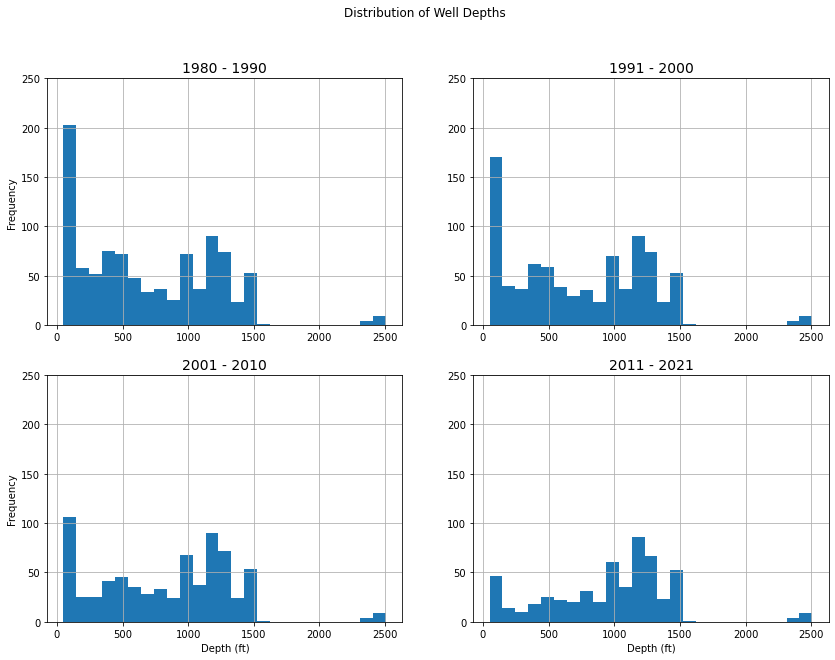

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (14,10))



fig.suptitle('Distribution of Well Depths')
df1990['Well Depth (ft)'].plot.hist(ax=ax1, bins=25, ylim=(0,250), grid=True).set_title("1980 - 1990", size=14)
df2000['Well Depth (ft)'].plot.hist(ax=ax2, bins=25, ylim=(0,250), grid=True).set_title("1991 - 2000", size=14)
df2010['Well Depth (ft)'].plot.hist(ax=ax3, bins=25, ylim=(0,250), grid=True).set_title("2001 - 2010", size=14)
df2021['Well Depth (ft)'].plot.hist(ax=ax4, bins=25, ylim=(0,250), grid=True).set_title("2011 - 2021", size=14)


#ax1.set(ylabel='Count')
ax2.set(ylabel=' ')
ax3.set(xlabel='Depth (ft)')
ax4.set(xlabel='Depth (ft)', ylabel= " ")


## Idea: redraw these distributions with 500 as the lowest depth?
## What are the average residensital and farm depths?
    

#### Pumping Capacity:

[Text(0.5, 0, 'Pump Capacity')]

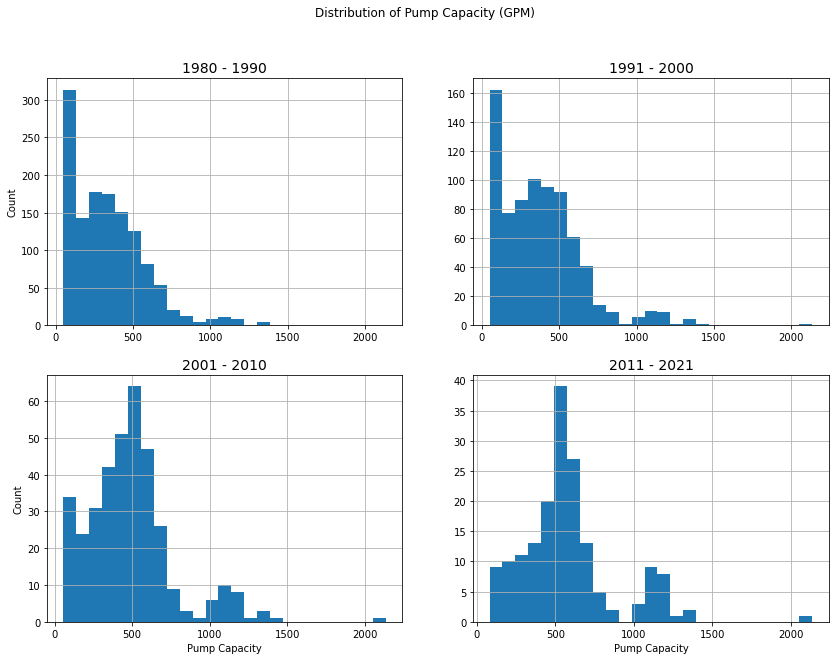

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (14,10))

fig.suptitle('Distribution of Pump Capacity (GPM)')
df_pump1990['Well Depth (ft)'].hist(ax=ax1, bins=25).set_title("1980 - 1990", size=14)
df_pump2000['Well Depth (ft)'].hist(ax=ax2, bins=25).set_title("1991 - 2000", size=14)
df_pump2010['Well Depth (ft)'].hist(ax=ax3, bins=25).set_title("2001 - 2010", size=14)
df_pump2021['Well Depth (ft)'].hist(ax=ax4, bins=25).set_title("2011 - 2021", size=14)

ax1.set(ylabel='Count')
ax3.set(xlabel='Pump Capacity', ylabel='Count')
ax4.set(xlabel='Pump Capacity',)

In [24]:
df.groupby(['Type']).size().describe()

count      8.000000
mean     121.500000
std      128.997231
min        9.000000
25%       52.750000
50%       79.500000
75%      145.250000
max      416.000000
dtype: float64

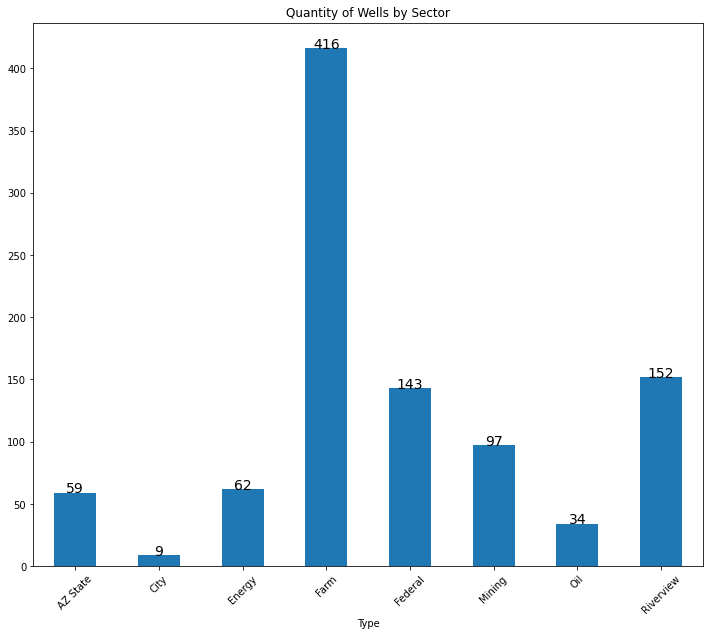

In [25]:
# let's see this all on a chart.

def addlabels(x,y):
    for i in range(len(y)):
        plt.text(i, y[i], y[i], ha = 'center', size='14')
        
df.groupby(['Type']).size().plot.bar(rot=45, figsize = (12,10)).set_title("Quantity of Wells by Sector")

addlabels(df['Type'], df.groupby(['Type']).size())


#df1960.plot.bar(x='Type', y=len(df1960['Owner']))

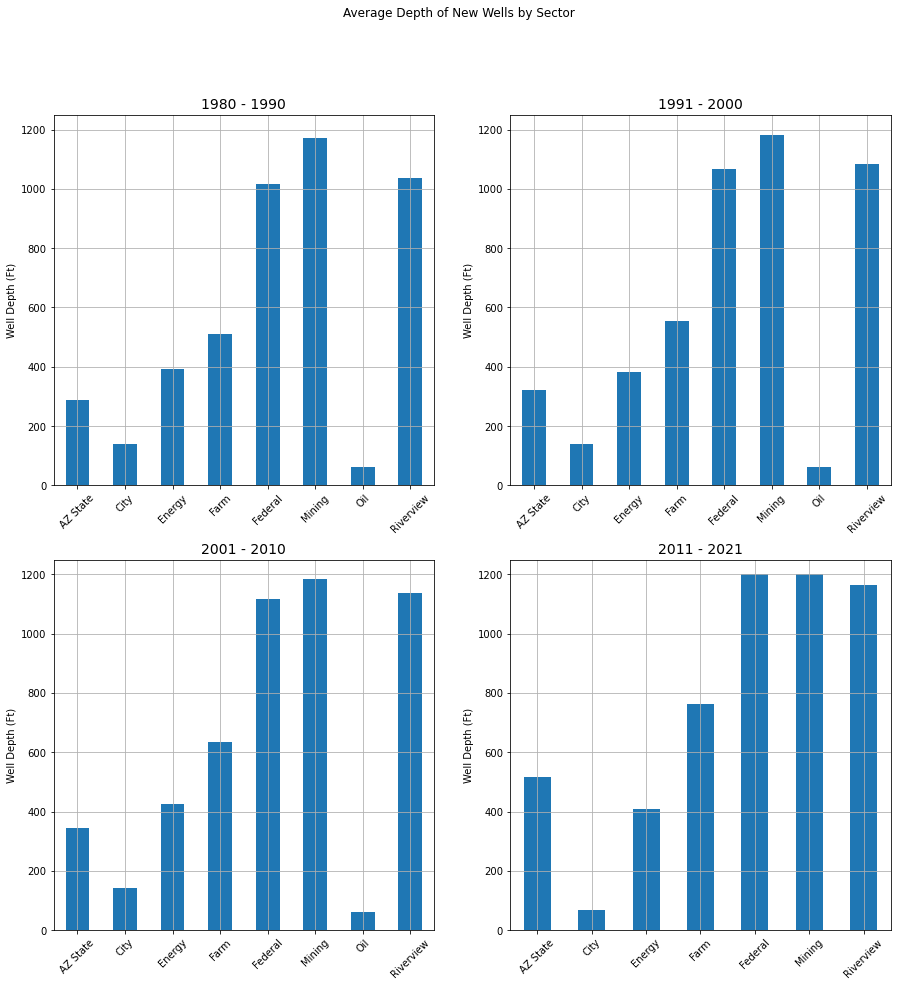

In [26]:
avgs1990 = df1990.groupby(['Type']).mean()
avgs2000 = df2000.groupby(['Type']).mean()
avgs2010 = df2010.groupby(['Type']).mean()
avgs2021 = df2021.groupby(['Type']).mean()


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize= (15,15))
fig.suptitle("Average Depth of New Wells by Sector")

#ax5 = ax1.twinx().twiny()

avgs1990['Well Depth (ft)'].plot.bar(ax=ax1, rot=45, grid=True, ylim=(0,1250)).set_title("1980 - 1990", size=14)
avgs2000['Well Depth (ft)'].plot.bar(ax=ax2, rot=45, grid=True, ylim=(0,1250)).set_title("1991 - 2000", size=14)
avgs2010['Well Depth (ft)'].plot.bar(ax=ax3, rot=45, grid=True, ylim=(0,1250)).set_title("2001 - 2010", size=14)
avgs2021['Well Depth (ft)'].plot.bar(ax=ax4, rot=45, grid=True, ylim=(0,1250)).set_title("2011 - 2021", size=14)

for ax in fig.get_axes():
    ax.set(xlabel='', ylabel='Well Depth (Ft)')


# Compare the growth of farm avg well depth and riverview farm depth.
# It looks like farms are "chasing" riverviews' depth. 
# Explore this trend more.

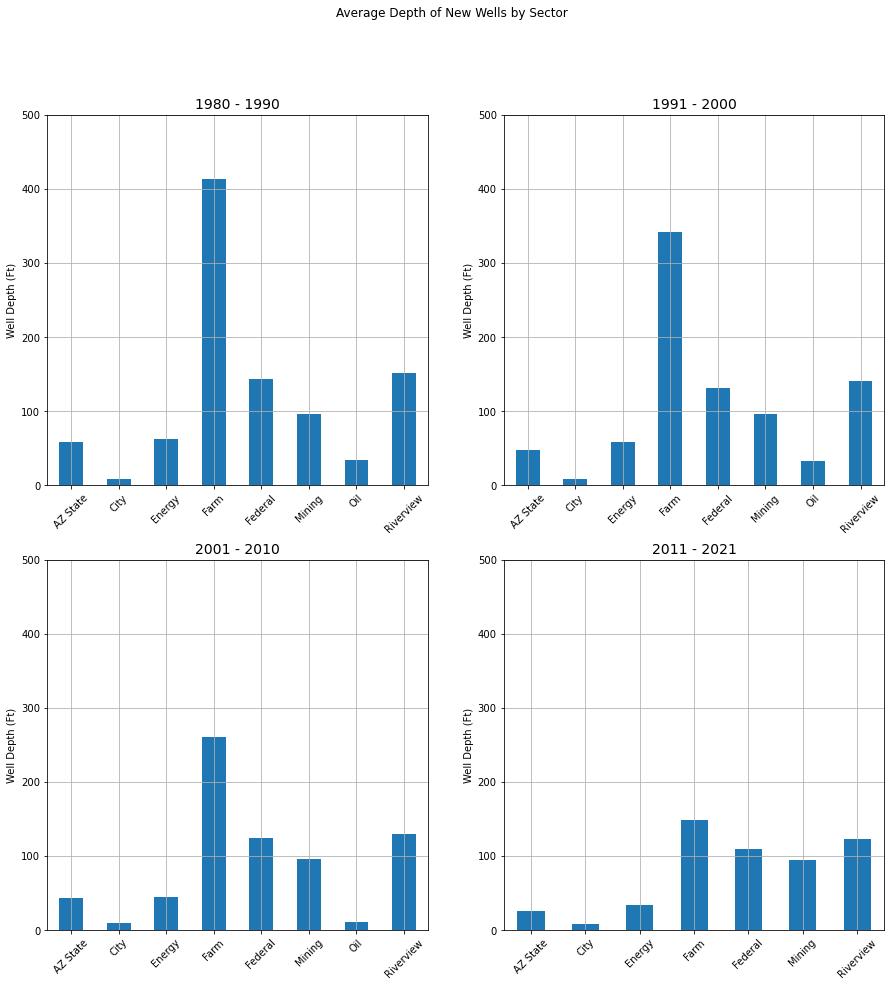

In [27]:
def addlabels(x,y):
    for i in range(len(y)):
        plt.text(i, y[i], y[i], ha = 'center', size=14)
        
#plot.bar(rot=45, figsize=(12,10)).set_title("Quantity of Wells by Sector", size=20)

ct_1990 = df1990.groupby(['Type']).size()
ct_2000 = df2000.groupby(['Type']).size()
ct_2010 = df2010.groupby(['Type']).size()
ct_2021 = df2021.groupby(['Type']).size()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize= (15,15))
fig.suptitle("Average Depth of New Wells by Sector")

ct_1990.plot.bar(ax=ax1, rot=45, grid=True, ylim=(0,500)).set_title("1980 - 1990", size=14)
ct_2000.plot.bar(ax=ax2, rot=45, grid=True, ylim=(0,500)).set_title("1991 - 2000", size=14)
ct_2010.plot.bar(ax=ax3, rot=45, grid=True, ylim=(0,500)).set_title("2001 - 2010", size=14)
ct_2021.plot.bar(ax=ax4, rot=45, grid=True, ylim=(0,500)).set_title("2011 - 2021", size=14)

for ax in fig.get_axes():
    ax.set(xlabel='', ylabel='Well Depth (Ft)')



# addlabels(df['Type'], df.groupby(['Type']).size())



In [28]:
# Any difference in the average water level for newer wells, drilled since 2010?

df_residential['Well Depth (ft)'].mean()

367.7502923976608

In [29]:
## how about a box-whisker plot of the Water Levels since 1860? 

## Is there any USGS data I could use? I don't think there is for Willcox and Douglas but maybe..?

Given the above chart, we see an increasing difference between the average water level and the well depth. 

Between 1970 and 1995-ish, the 10 year moving average well depth was decreasing. Why? Were people not worried about running out of water? Trying to save money on well drilling? 


Fundamental research needed:

Were there any lifting of regulations that occured between 1960 and today?

To explore:
The max values for years 2019-2021 look identical. Has there been a max well depth regulation put in place? What is the reasoning behind this? I suspect most of these are drilled by riverview, based on a "magic number" of depth they came up with.

What's going on with these wells that are ~40ft deep? Need to look at the actual water level. If the water level is much lower than the well depth, it may be bad data.

# III. Analysis:

<AxesSubplot:title={'center':'Annual New Wells Drilled from 1870 - 2021'}, xlabel='Year'>

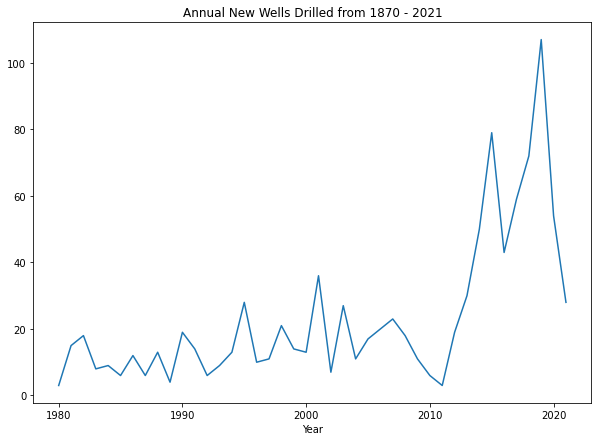

In [30]:
df_totbyyr = df.groupby(['Year']).size()
df_totbyyr.plot(title = "Annual New Wells Drilled from 1870 - 2021", figsize = (10,7))

<AxesSubplot:title={'center':'Wells Drilled by Riverview since 2011'}, xlabel='Year'>

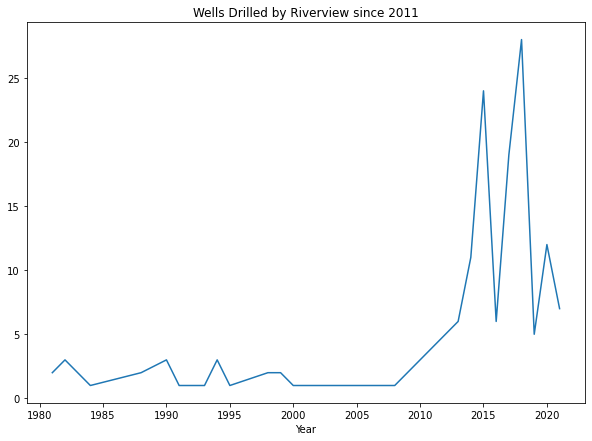

In [31]:
# Fix axis 

df_rvbyyr = df_rv.groupby(['Year']).size()
df_rvbyyr.plot(title = "Wells Drilled by Riverview since 2011", figsize = (10,7))

Text(0.5, 1.0, 'Percentage of total wells in county that were drilled by Riverview')

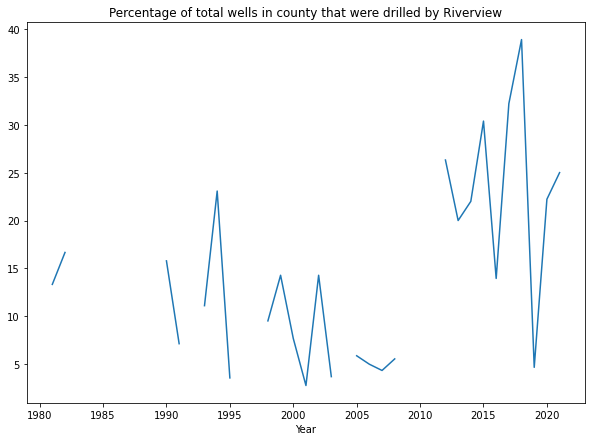

In [48]:
# Percentage of total wells in county that were drilled by Riverview:
df_rv_perc = (df_rvbyyr / df_totbyyr) * 100

df_rv_perc.plot(figsize = (10,7)).set_title("Percentage of total wells in county that were drilled by Riverview")

#In 2018, they drilled 25% of all the wells in the entire county

<AxesSubplot:>

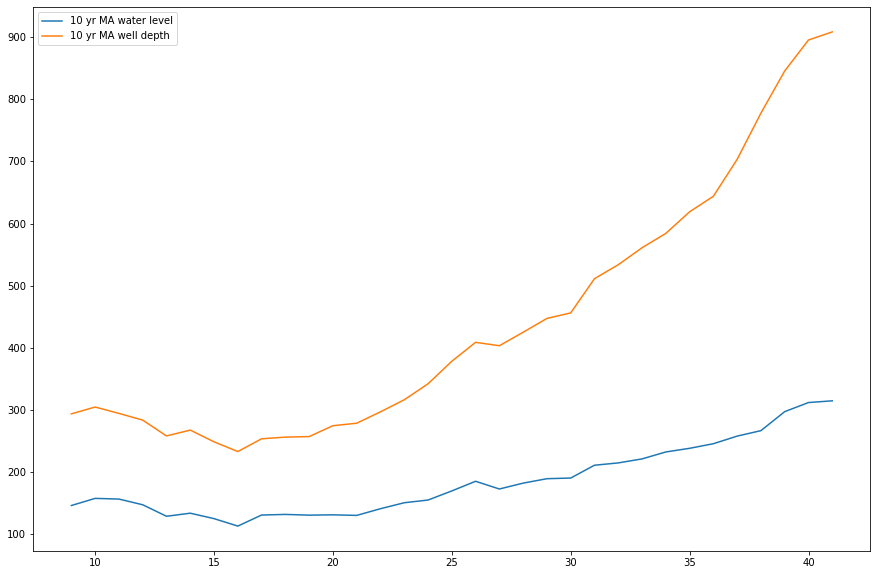

In [38]:
mean_waterlvl = df.groupby(['Year']).mean().reset_index()
mean_waterlvl.set_index('Year')

mean_waterlvl['10 yr MA water level'] = mean_waterlvl['Water Level (ft)'].rolling(10).mean()

mean_waterlvl['10 yr MA well depth'] = mean_waterlvl['Well Depth (ft)'].rolling(10).mean()

# why does it distort my plot when i try to add these as xticks?
xi = np.linspace(1960,2020,61)

mean_waterlvl[['10 yr MA water level', '10 yr MA well depth']].plot(figsize = (15,10))



### A larger difference between well depth and actual water level (charted below) represents greed and fear -- anticipation of ground water levels declining and a drive to monopolize access. 


<AxesSubplot:title={'center':'Absolute Difference in Water Level and Well Depth (ft)'}>

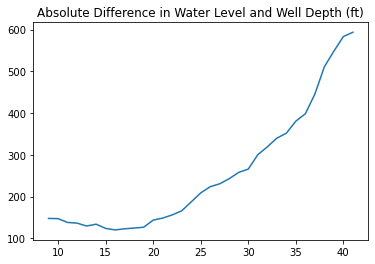

In [34]:
mean_difference = (mean_waterlvl['10 yr MA water level'] - mean_waterlvl['10 yr MA well depth']).abs()
mean_difference.plot(title="Absolute Difference in Water Level and Well Depth (ft)")


# FIXME: Add in yearly ticks on x axis

### Ideas:

1. Can I calculate or estimate the pumping for Riverview?
I'm sure I have their pumping capacity in GPH... I could estimate their use between 75%-95% power?
Given the size of their field (can I find data for their acrage of fields? if not, calculate by num wells * avg field acres?) altho maybe some fields share wells...

2. Is there something that hyperspectral data could tell me? Time series data of ground temperatures, change in vegetation index? Could ask Dr. Didan or Ales?


### Other resources:

"90 percent of the ground-water pumpage is for agriculture"
"Ground water is the main source of water in this area owing to the sparse surface-water resources"
"The combined estimated ground-water pumpage in both basins from 1915 to 2000 was more than 12 million acre-feet"

"In 1965, the State Land Commission declared much of the Douglas Basin a Critical Groundwater area because the large withdrawals for irrigation resulted in large water-level declines. The commission prohibited drilling new irrigation wells except to replace existing wells. The Critical Groundwater area became the Douglas Irrigated Non-Expansion Area (INA) with the passage of the 1980 Groundwater Management Act. The INA designation means that only land irrigated any time between 1975 and 1980 can be irrigated with ground water (Rascona, 1993). <b>There is no such limitation on irrigation in the Willcox Basin." </b>

</b> from https://www.arizonawaterdefenders.com/public-record-requests :</b> 
The approval of these applications by ADWR allowed growers in the INA to transfer portions of their existing grandfathered irrigation rights over to other properties within the INA.

In some cases, the approval of these applications allowed some of the biggest water users in the INA to commence new irrigation on large swaths of land that had no grandfathered irrigation rights-- <b>thus substantially expanding irrigation within the irrigation non-expansion area.</b>

Also in the AZ Water Defenders "Public Record Requests" page is Complaints to AZWR from Jan 2015 - Apr 2021.





^^ I should be able to calculate this. Would definitely benefit from grabbing seperate data for Willcox and Douglas basins. 

https://pubs.usgs.gov/fs/2006/3055/
Investigation of the Hydrologic Monitoring Network of the Willcox
and Douglas Basins of Southeastern Arizona: A Project of the Rural Watershed Initiative
